# **Import libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, BatchNormalization, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import os

2025-06-21 15:35:47.235134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750520147.463856      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750520147.528968      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Load data**

In [2]:
train_path = '/kaggle/input/4-animal-classification/train'

X_train, y_train = [], []
mp = {}
for label_name in os.listdir(train_path):
    sub_dir = os.path.join(train_path, label_name)
    mp[label_name] = 0
    for sub_dirp in os.listdir(sub_dir):
        mp[label_name] = mp[label_name] + 1
        file = os.path.join(sub_dir, sub_dirp)
        img = imread(file)
        img = resize(img, (224, 224), preserve_range=True)
        img = img.astype(np.float32)
        X_train.append(img)
        y_train.append(label_name)

In [3]:
other_path = '/kaggle/input/coco-subset-for-pose-estimation/dataset/train'
mp['other'] = 0
d = 0
for sub_dir in os.listdir(other_path):
    if d == 1000:
        break
    d = d + 1
    file = os.path.join(other_path, sub_dir)
    mp['other'] = mp['other'] + 1
    img = imread(file)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    elif img.ndim == 3 and img.shape[2] == 4:
        img = img[..., :3]
    elif img.ndim != 3 or img.shape[2] != 3:
        print(f"Unexpected shape {img.shape} at {file}, skipping.")
        continue
    img = resize(img, (224, 224), preserve_range=True)
    img = img.astype(np.float32)
    X_train.append(img)
    y_train.append('other')

In [4]:
print(mp)

{'horse': 600, 'dog': 900, 'cat': 700, 'deer': 600, 'other': 1000}


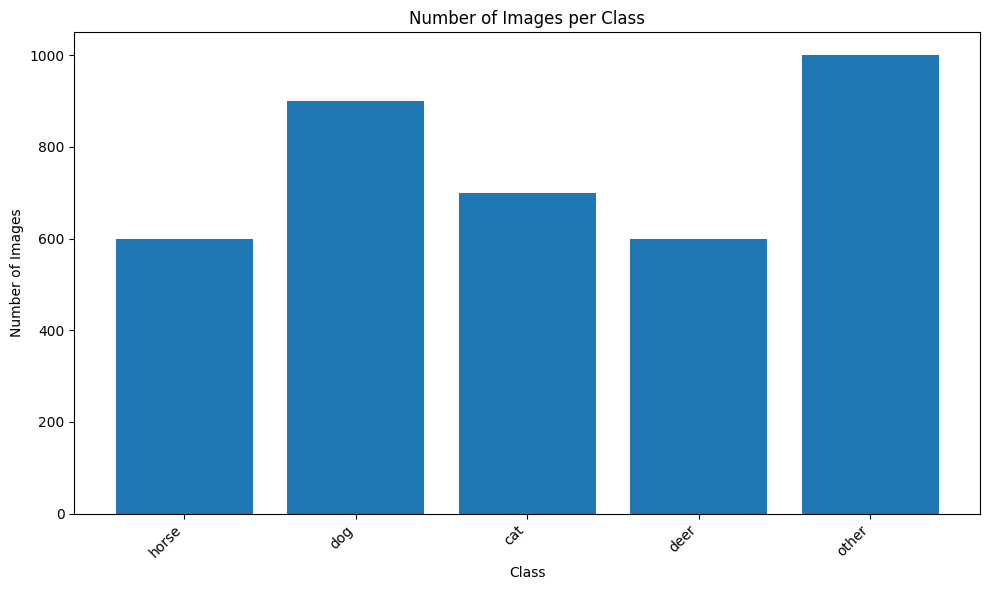

In [5]:
labels = list(mp.keys())
counts = list(mp.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
test_path = '/kaggle/input/4-animal-classification/test/test'

X_test, id_sub = [], []
for sub_dir in os.listdir(test_path):
    file = os.path.join(test_path, sub_dir)
    img = imread(file)
    img = resize(img, (224, 224), preserve_range=True)
    img = img.astype(np.float32)
    id_sub.append(sub_dir.split('.')[0])
    X_test.append(img)

In [7]:
X_train = np.array(X_train)

In [8]:
X_test = np.array(X_test)

In [9]:
X_train.shape

(3800, 224, 224, 3)

In [10]:
y_train = np.array(y_train)

In [11]:
print(y_train)

['horse' 'horse' 'horse' ... 'other' 'other' 'other']


In [12]:
ec = OneHotEncoder(sparse=False, categories=[['cat', 'deer', 'dog', 'horse', 'other']])

y_train = ec.fit_transform(y_train.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 19)

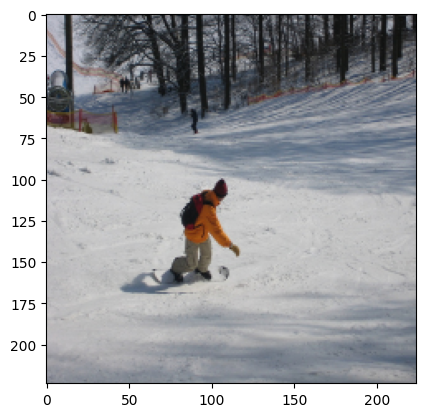

[['other']]


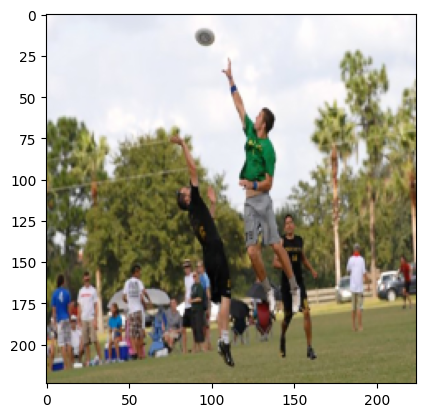

[['other']]


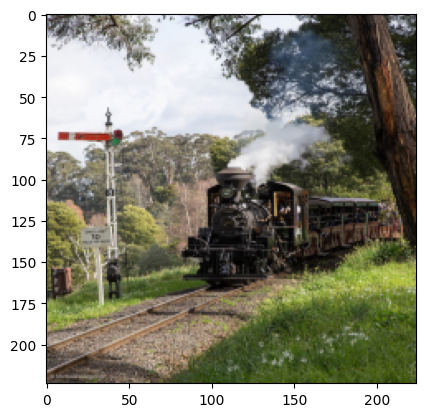

[['other']]


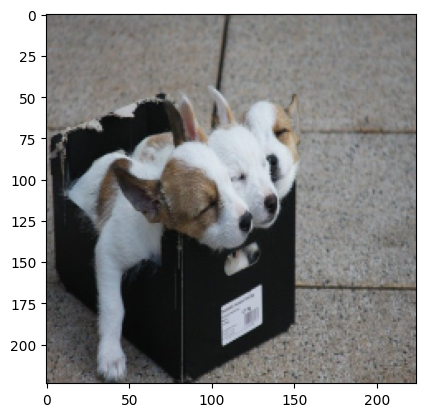

[['dog']]


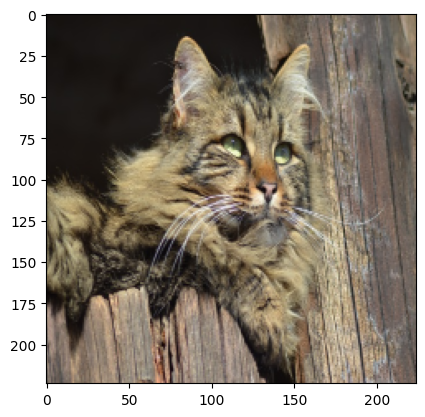

[['cat']]


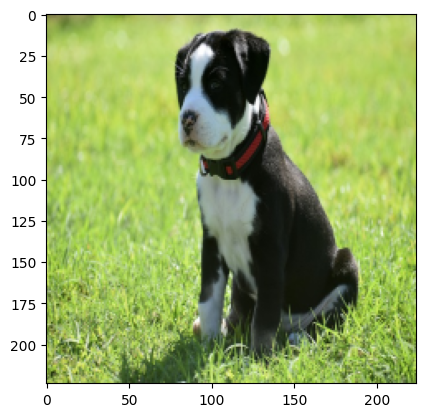

[['dog']]


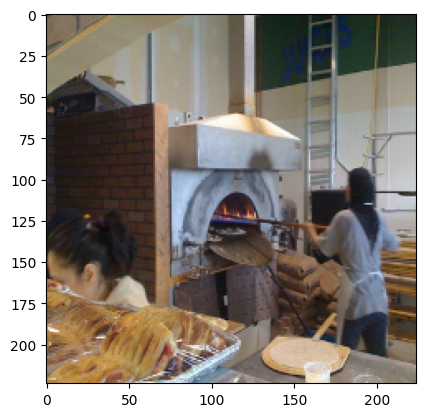

[['other']]


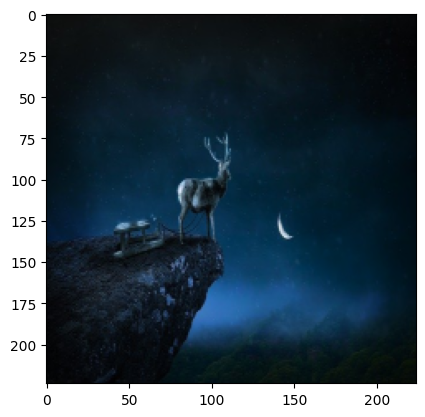

[['deer']]


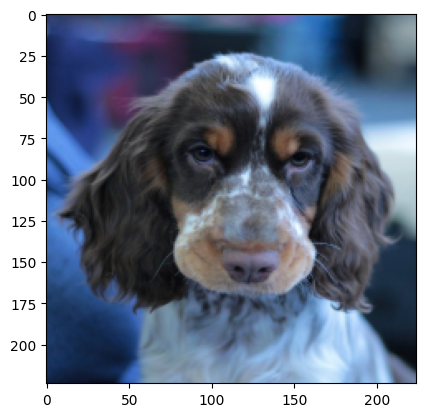

[['dog']]


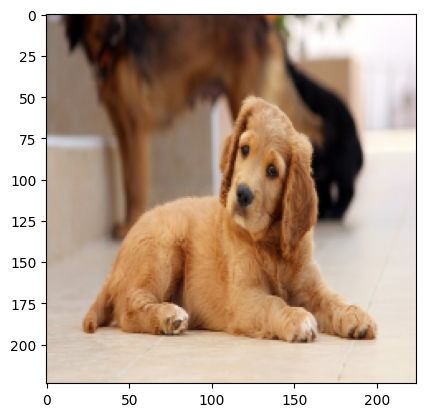

[['dog']]


In [14]:
for i in range(10):
    plt.imshow(X_train[i] / 255.0)
    plt.show()
    print(ec.inverse_transform([y_train[i]]))

In [15]:
X_train.shape

(3040, 224, 224, 3)

In [16]:
y_train.shape

(3040, 5)

In [17]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

# **Modeling**

## VGG16

In [18]:
def model(model_name):
  model = Sequential()
  # model.add(Lambda(preprocess_input)(Input(shape=(224, 224, 3))))
  for layer in model_name.layers:
    layer.trainable = False
    model.add(layer)
  return model

In [19]:
vgg16 = VGG16(weights='imagenet',include_top=False, input_tensor= Lambda(preprocess_input)(Input(shape=(224, 224, 3))))
model_vgg16 = model(vgg16)
model_vgg16.add(GlobalAveragePooling2D())
model_vgg16.add(Dense(4096, activation='relu'))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Dropout(0.2))

model_vgg16.add(Dense(4096, activation='relu'))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Dropout(0.2))

model_vgg16.add(Dense(5, activation='softmax'))
model_vgg16.summary()

I0000 00:00:1750520336.083566      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750520336.084163      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       2,101,2

 Total params: 33,650,501 (128.37 MB)

 Trainable params: 18,919,429 (72.17 MB)

 Non-trainable params: 14,731,072 (56.19 MB)

### No augmentation

In [20]:
model_vgg16.compile(optimizer= Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=16,      
    restore_best_weights=True 
)

history_vgg16 = model_vgg16.fit(X_train, y_train
                       , validation_data = (X_valid, y_valid)
                       , batch_size = 64, epochs = 100
                       , callbacks = [early_stop])

Epoch 1/100


I0000 00:00:1750520346.531831     105 service.cc:148] XLA service 0x7b0874019980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750520346.532582     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750520346.532606     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750520347.083522     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750520364.297390     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 64s 909ms/step - accuracy: 0.8137 - loss: 1.4064 - val_accuracy: 0.9026 - val_loss: 1.4279
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 357ms/step - accuracy: 0.9472 - loss: 0.1919 - val_accuracy: 0.9132 - val_loss: 0.9716
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 366ms/step - accuracy: 0.9777 - loss: 0.0686 - val_accuracy: 0.9355 - val_loss: 0.4378
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.9755 - loss: 0.0910 - val_accuracy: 0.9342 - val_loss: 0.3467
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 404ms/step - accuracy: 0.9853 - loss: 0.0394 - val_accuracy: 0.9145 - val_loss: 0.5486
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.9887 - loss: 0.0439 - val_accuracy: 0.9342 - val_loss: 0.4040
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 399ms/step - accuracy: 0.9924 - loss: 0.0170 - val_accuracy: 0.9355 - val_loss: 0.4506
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 393ms/step - accuracy: 0.9864 - loss: 0.0506 - val_accuracy

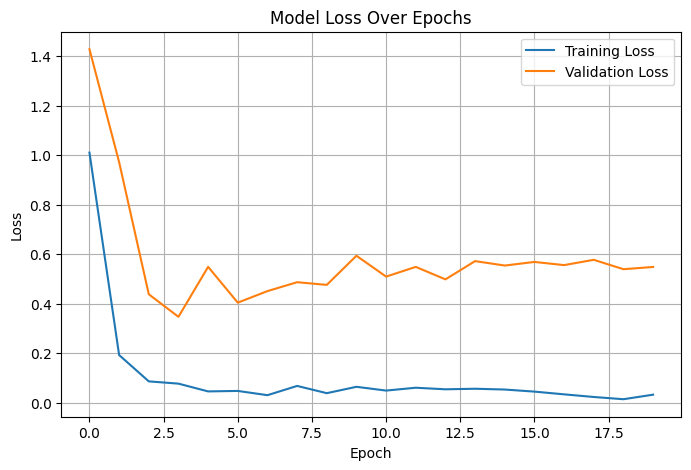

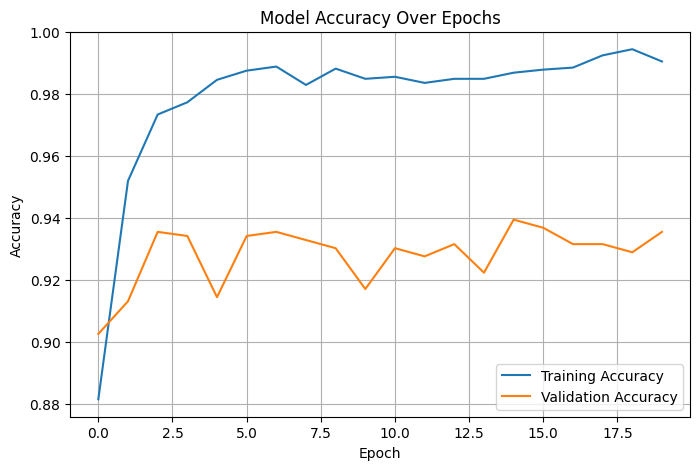

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(history_vgg16.history['loss'], label='Training Loss')
if 'val_loss' in history_vgg16.history:
    plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in history_vgg16.history or 'val_accuracy' in history_vgg16.history:
    plt.figure(figsize=(8, 5))
    if 'accuracy' in history_vgg16.history:
        plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history_vgg16.history:
        plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
y_pred = model_vgg16.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

submission1 = pd.read_csv('/kaggle/input/4-animal-classification/Sample_submission.csv')
submission1['ID'] = id_sub
submission1['Label'] = y_pred
submission1.to_csv('submission1_1.csv', index = False)

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 669ms/step


### Augmentation

In [24]:
vgg16_aug = VGG16(weights='imagenet',include_top=False, input_tensor= Lambda(preprocess_input)(Input(shape=(224, 224, 3))))
model_vgg16_aug = model(vgg16_aug)
model_vgg16_aug.add(GlobalAveragePooling2D())
model_vgg16_aug.add(Dense(4096, activation='relu'))
model_vgg16_aug.add(BatchNormalization())
model_vgg16_aug.add(Dropout(0.2))

model_vgg16_aug.add(Dense(4096, activation='relu'))
model_vgg16_aug.add(BatchNormalization())
model_vgg16_aug.add(Dropout(0.2))

model_vgg16_aug.add(Dense(5, activation='softmax'))
model_vgg16_aug.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │       2,101,2

 Total params: 33,650,501 (128.37 MB)

 Trainable params: 18,919,429 (72.17 MB)

 Non-trainable params: 14,731,072 (56.19 MB)

In [25]:
model_vgg16_aug.compile(optimizer= Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [27]:
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=64,
    shuffle=True,
    seed=19
)

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=16,      
    restore_best_weights=True 
)

history_vgg16_aug = model_vgg16_aug.fit(train_generator
                       , validation_data = (X_valid, y_valid)
                       , batch_size = 64, epochs = 100
                       , callbacks = [early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 826ms/step - accuracy: 0.7456 - loss: 1.8782 - val_accuracy: 0.9013 - val_loss: 2.0798
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 742ms/step - accuracy: 0.8979 - loss: 0.4196 - val_accuracy: 0.9026 - val_loss: 0.7473
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 740ms/step - accuracy: 0.9092 - loss: 0.2868 - val_accuracy: 0.9276 - val_loss: 0.3825
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 752ms/step - accuracy: 0.9221 - loss: 0.2408 - val_accuracy: 0.9145 - val_loss: 0.3235
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 742ms/step - accuracy: 0.9411 - loss: 0.1871 - val_accuracy: 0.9171 - val_loss: 0.4033
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 714ms/step - accuracy: 0.9229 - loss: 0.2252 - val_accuracy: 0.9158 - val_loss: 0.4229
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 741ms/step - accuracy: 0.9185 - loss: 0.2608 - val_accuracy: 0.9066 - val_loss: 0.4432
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 767ms/step - accuracy: 0.9417 - loss: 0.2026 - 

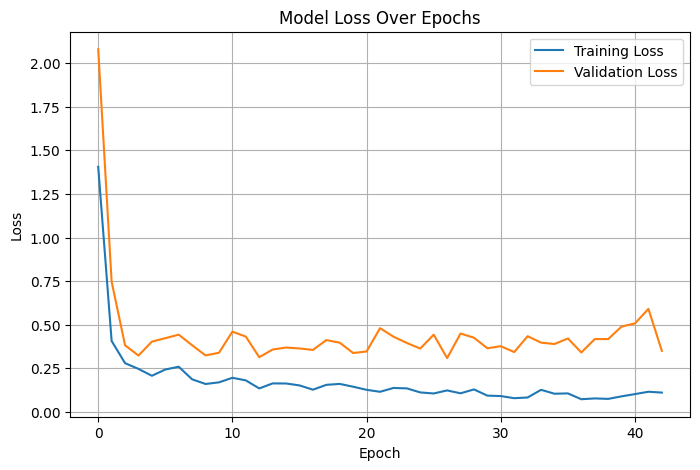

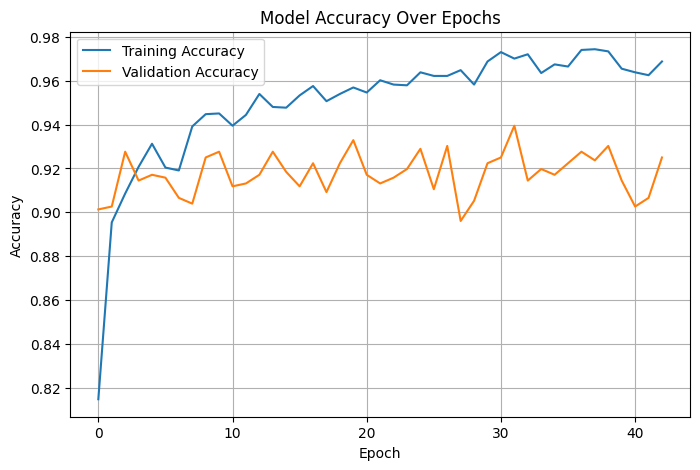

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(history_vgg16_aug.history['loss'], label='Training Loss')
if 'val_loss' in history_vgg16_aug.history:
    plt.plot(history_vgg16_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in history_vgg16_aug.history or 'val_accuracy' in history_vgg16_aug.history:
    plt.figure(figsize=(8, 5))
    if 'accuracy' in history_vgg16_aug.history:
        plt.plot(history_vgg16_aug.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history_vgg16_aug.history:
        plt.plot(history_vgg16_aug.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
y_pred = model_vgg16.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

submission2 = pd.read_csv('/kaggle/input/4-animal-classification/Sample_submission.csv')
submission2['ID'] = id_sub
submission2['Label'] = y_pred
submission2.to_csv('submission2_1.csv', index = False)

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step


## Resnet 50

In [31]:
class ResNet:
    def __init__(self,
                 input_shape=(224, 224, 3),
                 lr: float = 1e-3):
        
        self.input_shape = input_shape
        self.lr = lr
        self.model: tf.keras.Model = None

    def build(self):
        inputs = Input(shape=self.input_shape)

        x = Lambda(preprocess_input, name="preprocessing")(inputs)

        base = ResNet50(
            weights='imagenet',
            include_top=False,
            input_tensor=x
        )
        base.trainable = False

        x = GlobalAveragePooling2D(name="gap")(base.output)

        x = Dense(4096, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate = 0.2)(x)

        x = Dense(4096, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate = 0.2)(x)
        
        output = Dense(5, activation='softmax', name="predictions")(x)

        self.model = Model(inputs=inputs, outputs=output, name="ResNet50_4cls")
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return self.model

    def summary(self):
        self.model.summary()

### No augmentation

In [32]:
resnet50 = ResNet()
resnet50 = resnet50.build()
print(resnet50.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50_4cls"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ preprocessing (Lambda)    │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ preprocessing[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 48,814,981 (186.21 MB)

 Trainable params: 25,210,885 (96.17 MB)

 Non-trainable params: 23,604,096 (90.04 MB)

None


In [33]:
early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=16,      
    restore_best_weights=True 
)

history_resnet50 = resnet50.fit(X_train, y_train
                       , validation_data = (X_valid, y_valid)
                       , batch_size = 64, epochs = 100
                       , callbacks = [early_stop])

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 635ms/step - accuracy: 0.8342 - loss: 1.3731 - val_accuracy: 0.8868 - val_loss: 0.8723
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.9664 - loss: 0.1318 - val_accuracy: 0.9421 - val_loss: 0.3764
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.9803 - loss: 0.0751 - val_accuracy: 0.9342 - val_loss: 0.5465
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.9825 - loss: 0.0683 - val_accuracy: 0.9474 - val_loss: 0.3831
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.9855 - loss: 0.0555 - val_accuracy: 0.9395 - val_loss: 0.4759
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9882 - loss: 0.0529 - val_accuracy: 0.9408 - val_loss: 0.4457
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9881 - loss: 0.0366 - val_accuracy: 0.9447 - val_loss: 0.5540
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.9901 - loss: 0.0358 - 

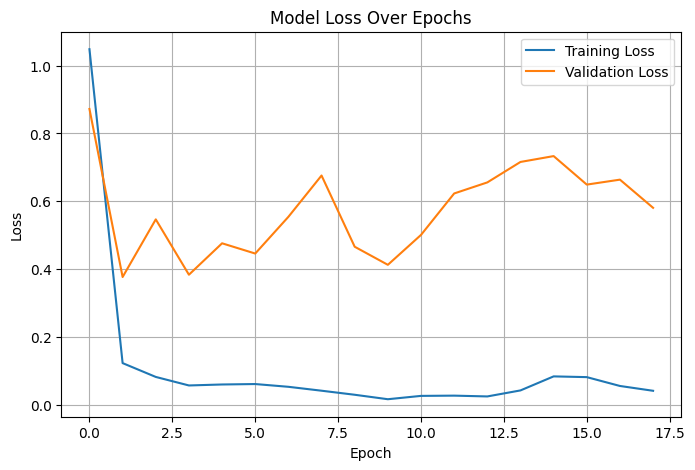

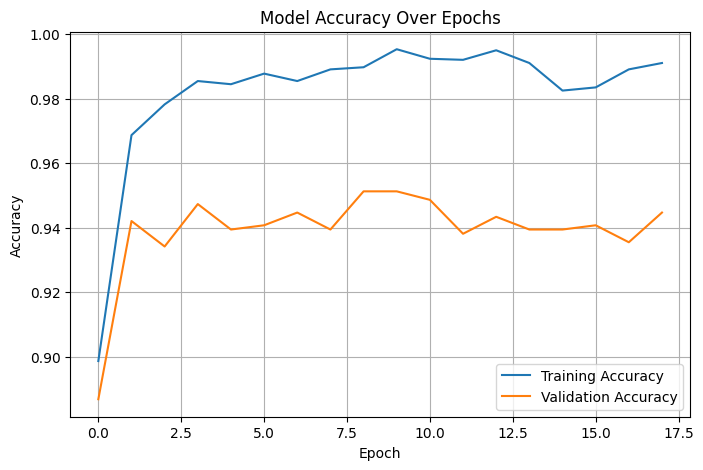

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(history_resnet50.history['loss'], label='Training Loss')
if 'val_loss' in history_resnet50.history:
    plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in history_resnet50.history or 'val_accuracy' in history_resnet50.history:
    plt.figure(figsize=(8, 5))
    if 'accuracy' in history_resnet50.history:
        plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history_resnet50.history:
        plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [35]:
y_pred = resnet50.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 375ms/step


In [36]:
submission1 = pd.read_csv('/kaggle/input/4-animal-classification/Sample_submission.csv')
submission1['ID'] = id_sub
submission1['Label'] = y_pred
submission1.to_csv('submission1_2.csv', index = False)

### Augmentation

In [37]:
resnet50_aug = ResNet()
resnet50_aug = resnet50_aug.build()

In [38]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [39]:
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=64,
    shuffle=True,
    seed=19
)

In [40]:
early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=16,      
    restore_best_weights=True 
)

history_resnet50_aug = resnet50_aug.fit(train_generator
                           , validation_data = (X_valid, y_valid)
                           , batch_size = 64, epochs = 100
                           , callbacks = [early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 57s 885ms/step - accuracy: 0.8044 - loss: 1.5408 - val_accuracy: 0.9132 - val_loss: 0.9595
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 690ms/step - accuracy: 0.9388 - loss: 0.3743 - val_accuracy: 0.9289 - val_loss: 0.3489
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 680ms/step - accuracy: 0.9451 - loss: 0.1858 - val_accuracy: 0.9184 - val_loss: 0.5233
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 676ms/step - accuracy: 0.9647 - loss: 0.1173 - val_accuracy: 0.9395 - val_loss: 0.2383
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 677ms/step - accuracy: 0.9632 - loss: 0.1223 - val_accuracy: 0.9592 - val_loss: 0.2507
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 675ms/step - accuracy: 0.9644 - loss: 0.1077 - val_accuracy: 0.9461 - val_loss: 0.3280
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 690ms/step - accuracy: 0.9604 - loss: 0.1129 - val_accuracy: 0.9461 - val_loss: 0.3442
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 713ms/step - accuracy: 0.9658 - loss: 0.1261 - 

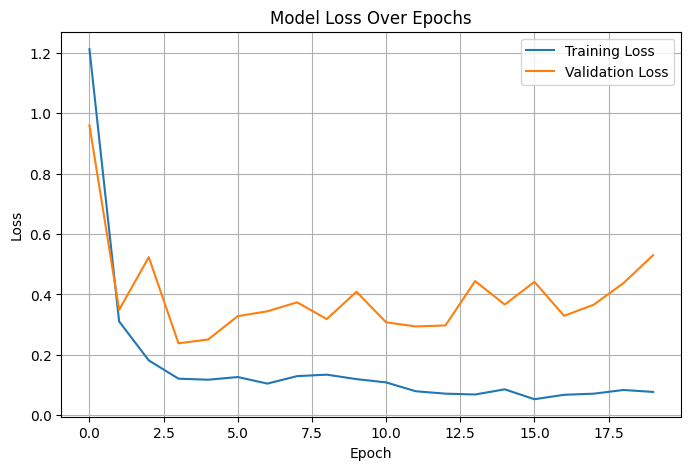

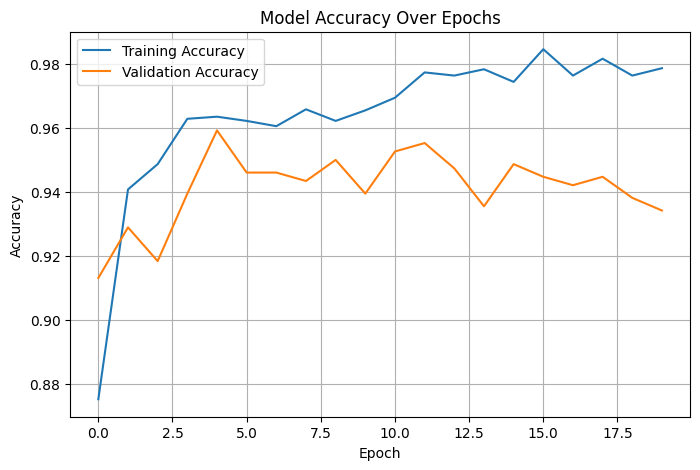

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(history_resnet50_aug.history['loss'], label='Training Loss')
if 'val_loss' in history_resnet50_aug.history:
    plt.plot(history_resnet50_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in history_resnet50_aug.history or 'val_accuracy' in history_resnet50_aug.history:
    plt.figure(figsize=(8, 5))
    if 'accuracy' in history_resnet50_aug.history:
        plt.plot(history_resnet50_aug.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history_resnet50_aug.history:
        plt.plot(history_resnet50_aug.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
y_pred = resnet50.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


In [43]:
submission2 = pd.read_csv('/kaggle/input/4-animal-classification/Sample_submission.csv')
submission2['ID'] = id_sub
submission2['Label'] = y_pred
submission2.to_csv('submission2_2.csv', index = False)

# **Compare model**

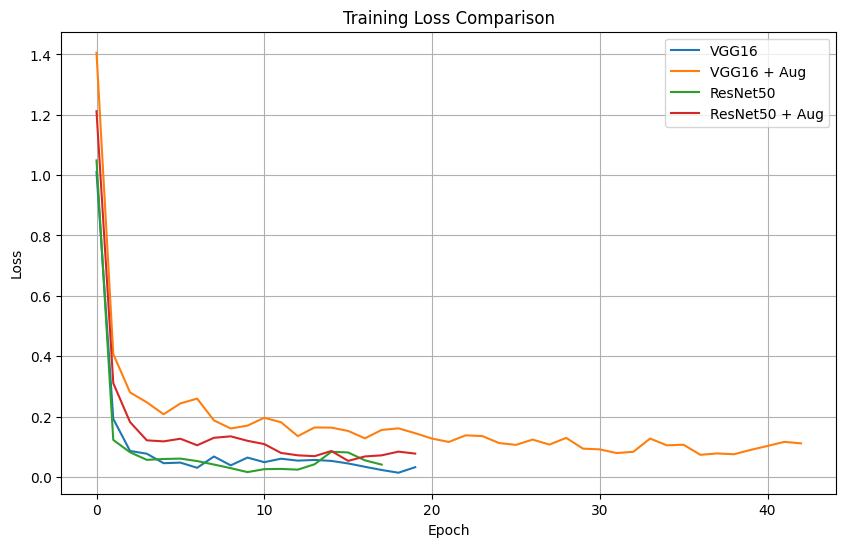

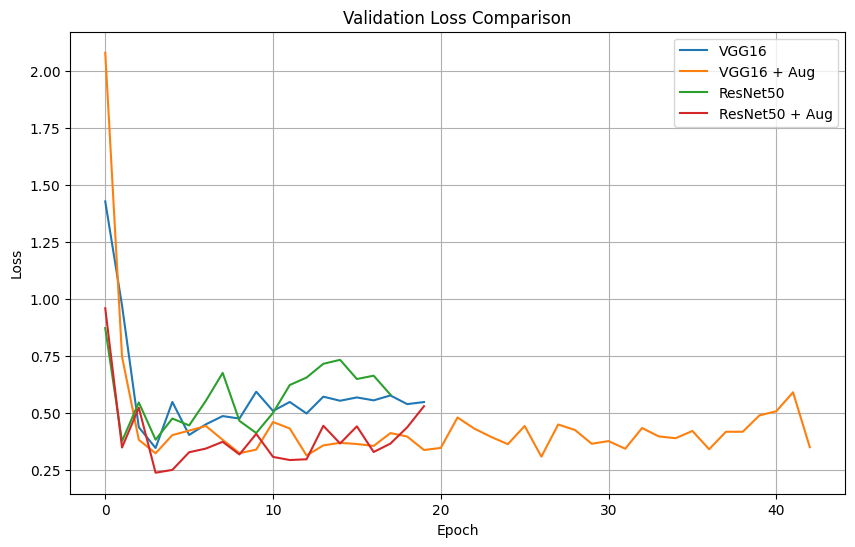

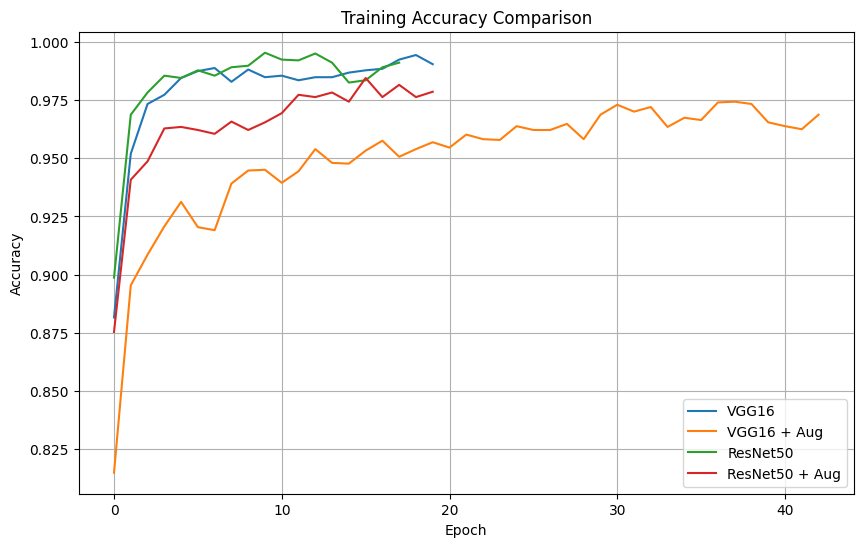

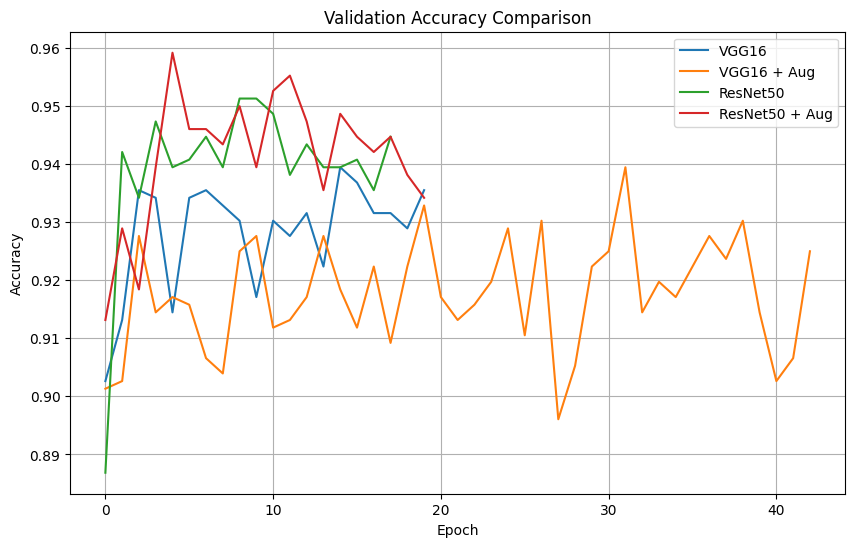

In [44]:
import matplotlib.pyplot as plt

histories = {
    'VGG16': history_vgg16,
    'VGG16 + Aug': history_vgg16_aug,
    'ResNet50': history_resnet50,
    'ResNet50 + Aug': history_resnet50_aug
}

def plot_metric(metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        if metric in history.history:
            plt.plot(history.history[metric], label=name)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Vẽ 4 biểu đồ
plot_metric('loss', 'Training Loss Comparison', 'Loss')
plot_metric('val_loss', 'Validation Loss Comparison', 'Loss')
plot_metric('accuracy', 'Training Accuracy Comparison', 'Accuracy')
plot_metric('val_accuracy', 'Validation Accuracy Comparison', 'Accuracy')

# Make fun predict

In [45]:
def predict_image(link):
    img = imread(link)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    elif img.ndim == 3 and img.shape[2] == 4:
        img = img[..., :3]
    elif img.ndim != 3 or img.shape[2] != 3:
        print(f"Unexpected shape {img.shape} at {file}, skipping.")
        return 0
    img = resize(img, (224, 224), preserve_range=True)
    img = img.astype(np.float32)
    img = np.array(img)
    
    plt.imshow(img / 255)
    
    img = np.expand_dims(img, 0)
    
    print(img.shape)
    
    mp = {0: 'cat'
          , 1: 'deer'
          , 2:'dog'
          , 3:'horse'
          , 4: 'other'}

    pred_vgg16 = model_vgg16.predict(img)
    lab = np.argmax(pred_vgg16, axis = 1)
    lab = [mp[x] for x in lab]
    print('Predicted by VGG16')
    print('label: ', lab, ' Accuracy: ', pred_vgg16.max(axis = 1))
    
    pred_vgg16_aug = model_vgg16_aug.predict(img)
    lab = np.argmax(pred_vgg16_aug, axis = 1)
    lab = [mp[x] for x in lab]
    print('Predicted by VGG16 with augmentation')
    print('label: ', lab, ' Accuracy: ', pred_vgg16_aug.max(axis = 1))
    
    pred_resnet50 = resnet50.predict(img)
    lab = np.argmax(pred_resnet50, axis = 1)
    lab = [mp[x] for x in lab]
    print('Predicted by resnet50')
    print('label: ', lab, ' Accuracy: ', pred_resnet50.max(axis = 1))
    
    pred_resnet50_aug = resnet50_aug.predict(img)
    lab = np.argmax(pred_resnet50_aug, axis = 1)
    lab = [mp[x] for x in lab]
    print('Predicted by resnet with augmentation')
    print('label: ', lab, ' Accuracy: ', pred_resnet50_aug.max(axis = 1))
    return 0

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted by VGG16
label:  ['other']  Accuracy:  [0.9999951]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Predicted by VGG16 with augmentation
label:  ['other']  Accuracy:  [0.99971324]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted by resnet50
label:  ['other']  Accuracy:  [1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted by resnet with augmentation
label:  ['other']  Accuracy:  [0.9999999]


0

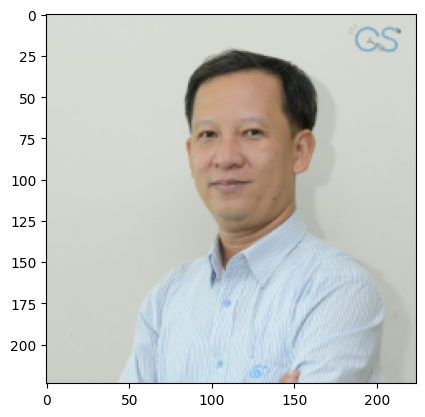

In [46]:
predict_image('/kaggle/input/thaydung/MaiTienDung-300x300.png')

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by VGG16
label:  ['dog']  Accuracy:  [0.9999733]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by VGG16 with augmentation
label:  ['dog']  Accuracy:  [0.9999999]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by resnet50
label:  ['dog']  Accuracy:  [0.9981451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by resnet with augmentation
label:  ['dog']  Accuracy:  [0.98914015]


0

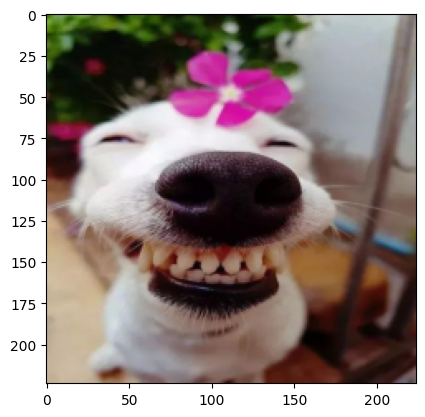

In [47]:
predict_image('/kaggle/input/conchoa/ti xung.jpg')

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by VGG16
label:  ['cat']  Accuracy:  [0.99999726]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by VGG16 with augmentation
label:  ['cat']  Accuracy:  [0.9985598]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by resnet50
label:  ['cat']  Accuracy:  [1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by resnet with augmentation
label:  ['cat']  Accuracy:  [1.]


0

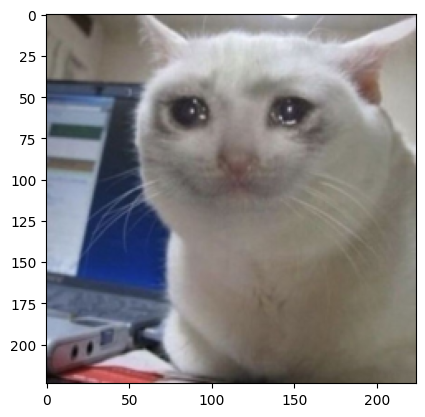

In [49]:
predict_image('/kaggle/input/conmeokhoc/meme-meo-khoc-7.jpg')

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by VGG16
label:  ['deer']  Accuracy:  [0.9999912]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by VGG16 with augmentation
label:  ['deer']  Accuracy:  [0.9997944]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted by resnet50
label:  ['deer']  Accuracy:  [0.99999535]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by resnet with augmentation
label:  ['deer']  Accuracy:  [0.99909985]


0

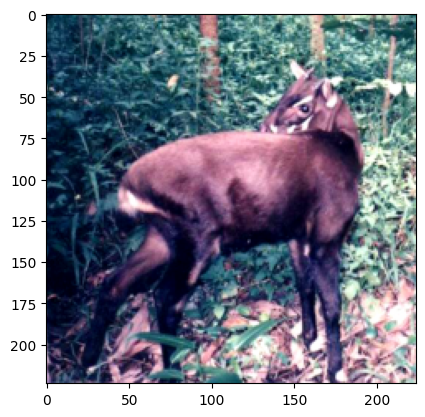

In [50]:
predict_image('/kaggle/input/saoooo/Pseudoryx_nghetinhensis_b.png')

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by VGG16
label:  ['horse']  Accuracy:  [0.9982926]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by VGG16 with augmentation
label:  ['horse']  Accuracy:  [0.9999311]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by resnet50
label:  ['horse']  Accuracy:  [0.99999404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by resnet with augmentation
label:  ['horse']  Accuracy:  [0.9960186]


0

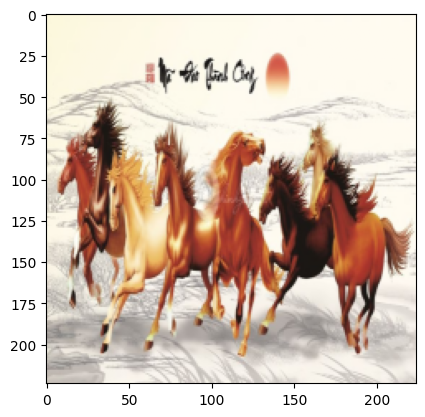

In [51]:
predict_image('/kaggle/input/madaothanhcong/mdtc36.jpg')

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by VGG16
label:  ['cat']  Accuracy:  [0.9920746]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by VGG16 with augmentation
label:  ['cat']  Accuracy:  [0.98478067]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by resnet50
label:  ['cat']  Accuracy:  [0.99970657]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by resnet with augmentation
label:  ['cat']  Accuracy:  [0.8399275]


0

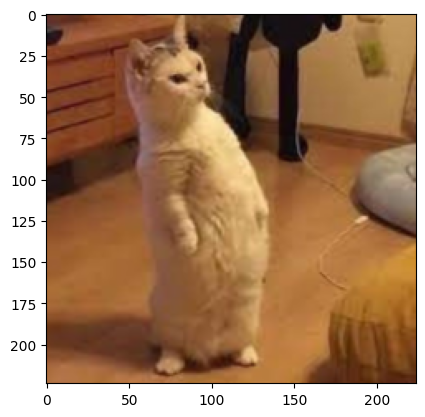

In [53]:
predict_image('/kaggle/input/conmeodung/meme-meo-bua-yody-vn-57.jpg')

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by VGG16
label:  ['dog']  Accuracy:  [0.9801199]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by VGG16 with augmentation
label:  ['dog']  Accuracy:  [0.8454931]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted by resnet50
label:  ['dog']  Accuracy:  [1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted by resnet with augmentation
label:  ['dog']  Accuracy:  [1.]


0

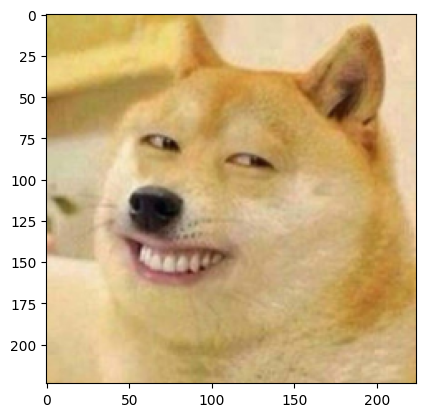

In [54]:
predict_image('/kaggle/input/con-chocuoi/f682b3d6fb501e560841e48039b1e2df.jpg')

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted by VGG16
label:  ['dog']  Accuracy:  [0.9991265]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by VGG16 with augmentation
label:  ['dog']  Accuracy:  [0.99999976]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted by resnet50
label:  ['dog']  Accuracy:  [0.9285069]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted by resnet with augmentation
label:  ['other']  Accuracy:  [0.7819843]


0

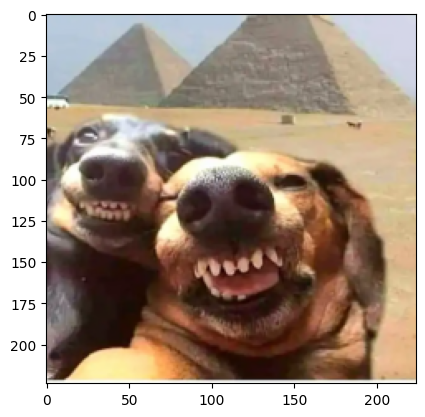

In [96]:
predict_image('/kaggle/input/2concho/meme-cho-cuoi-15.webp')